# Exámen Final : Clasificación de Imágenes en Celebridades, Animales y Caricaturas usando CNN
### Alumno: Renzo Alessandro Sucari Velásquez

#### **DataSets**: 

*   **Animal Faces**: [Link](https://www.kaggle.com/andrewmvd/animal-faces). Este conjunto de datos, también conocido como *Animal Faces-HQ* (AFHQ), consta de 16 130 imágenes de alta calidad con una resolución de 512x512.
Hay tres dominios de clases, cada uno de los cuales proporciona alrededor de 5000 imágenes. Al tener múltiples (tres) dominios e imágenes diversas de varias razas por cada dominio, AFHQ establece un desafiante problema de traducción de imagen a imagen. Las clases son: Gato, Perro y Fauna silvestre (leones, tigres, lobos, zorros, etc).
*   **Simpsons Faces**: [Link](https://www.kaggle.com/kostastokis/simpsons-faces). Este conjunto de datos fue construido inicialmente para un algoritmo llamado *CycleGAN* que transforma rostros humanos reales en rostros de caricatura de los Simpsons. El responsable de juntar estas imágenes, Konstantinos Tokis, utilizó un algoritmo de reconocimiento facial simple llamado *Simpsons Face Detector*, estas imágenes fueron extraídas de la temporada 25-28 de los Simpsons. Las imágenes recortadas se extraen directamente de los archivos de vídeo, solo presentan los ojos y la piel del rostro reconocido. Todas las imágenes son de 200x200 píxeles, cada una centrada en una sola cara, el conjunto de datos lleva como nombre Simpsons Faces.
*   **Pins Face Recognition**: [Link](https://www.kaggle.com/hereisburak/pins-face-recognition). Estas imágenes han sido recopiladas de Pinterest y recortadas. Hay 105 celebridades y 17534 caras.







In [ ]:
rm "modelo_aprendido.pt"

In [ ]:
!rm -rf "/content/__MACOSX"

In [ ]:
!rm -rf "TheSimpson"

In [ ]:
rm "TheSimpson.zip"

## 1. Importamos las Librerias

In [1]:
import torch
import numpy as np  # estándar universal para trabajar con datos numéricos en Python.
from torchvision import datasets # para acceder a conjuntos de datos de imágenes y videos.
import torchvision.transforms as transforms # para transformar la entrada.
from torch.utils.data.sampler import SubsetRandomSampler #para especificar la secuencia de índices/keys utilizadas en la carga de datos.

## 2. Hiperparametros y Transformaciones

In [2]:
# Cantidad de muestras por lote(batch) que se cargaran
batch_size = 32
# Porcentaje del dataset que se usara para las pruebas
test_size = 0.1
# Porcentaje del dataset que se usara para la validacion
valid_size = 0.1

# Convertir la data a un torch.FloatTensor normalizado(224 X 224)
# transforms.ToTensor() convierte la imagen en un tensor de forma (C x H x W) en el rango [0,1] 
# C - Numero de canales
# H - altura
# W - ancho
# transforms.Normalize(mean,std) normaliza un tensor a (mean, std) para (R, G, B)
transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    #transforms.Resize(size=(100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

## 3. Carga de los Datos


In [3]:
!unzip -q "TheSimpson.zip"

In [4]:
# Cargamos y aplicamos las transformaciones a todo nuestro dataset
# root: ruta del directorio raíz.
# transform: Una función/transformación que toma una imagen PIL y devuelve una versión transformada.
data = datasets.ImageFolder('./TheSimpson/Training',transform=transform)

# Estamos trabajando con 4 sujetos
num_classes = 4

# Datos para testing
num_data = len(data)
indices_data = list(range(num_data)) # Indizamos la data
np.random.shuffle(indices_data)  # Barajamos la indizacion.
split_tt = int(np.floor(test_size * num_data)) # Porcentaje de Split
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt] # Split

# Datos para validacion
num_train = len(train_idx)
indices_train = list(range(num_train)) # Indizamos la data (train)
np.random.shuffle(indices_train) # Barajamos la indizacion.
split_tv = int(np.floor(valid_size * num_train)) # Porcentaje de Split
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv] # Split

# Definimos samplers para obtener lotes(batches) de entrenamiento y validacion 
# SubsetRandomSampler: Muestra elementos de forma aleatoria de una lista determinada de índices
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# DataLoader: envuelve un iterable alrededor del conjunto de datos para permitir un fácil acceso a las muestras.
# dataset - conjunto de datos desde el que cargar los datos.
# batch_size - cuántas muestras se deben cargar por lote.
# sampler - define la estrategia para extraer muestras del conjunto de datos.
# num_workers - cuántos subprocesos se deben usar para la carga de datos.
train_loader = torch.utils.data.DataLoader(data, 
                                           batch_size=batch_size,
                                           sampler=train_sampler, 
                                           num_workers=1
                                           )
valid_loader = torch.utils.data.DataLoader(data,
                                           batch_size=batch_size, 
                                           sampler=valid_sampler, 
                                           num_workers=1
                                           )
test_loader = torch.utils.data.DataLoader(data, 
                                          sampler = test_sampler, 
                                          batch_size=batch_size, 
                                          num_workers=1
                                          )

# Definición de las clases presentes en el conjunto de datos. 
# Tenemos 4 clases diferentes en este conjunto de datos.
classes = ['Homero', 'Marge', 'Bart', 'Lisa']

print('Cantidad de archivos: ' + str(num_data))
print('# de archivos Train: ', len(train_sampler))
print('# de archivos Test: ', len(test_sampler))
print('# de archivos Validación: ', len(valid_sampler))


Cantidad de archivos: 600
# de archivos Train:  486
# de archivos Test:  60
# de archivos Validación:  54


In [5]:
data

Dataset ImageFolder
    Number of datapoints: 600
    Root location: ./TheSimpson/Training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

## 4. Visualizacion de los datos

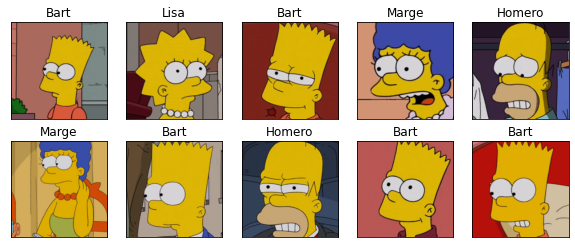

In [8]:
import matplotlib.pyplot as plt # Gráficos
%matplotlib inline

# Definimos la función auxiliar "imshow" que realiza la desnormalización y la 
# convierte a una forma numpy para mostrar la imagen original.
def imshow(img):
    img = img / 2 + 0.5  #des-normalizar
    plt.imshow(np.transpose(img, (1, 2, 0)))  #convertir desde Tensor image
    
# Obtenemos un lote(batch) de imagenes de entrenamiento
dataiter = iter(train_loader)
images, labels = dataiter.next() # listamos las imagenes y sus etiquetas crudas
images = images.numpy() # convertir imagenes a numpy para mostrarlas

# Ploteamos the imagenes del batch, con sus correspondientes etiquetas
fig = plt.figure(figsize=(10, 4))
#Mostramos 20 imagenes
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## 5. Definición de la arquitectura de la Red Neuronal - CNN

Comenzamos con la imagen de entrada siendo de dimensiones (224,224,3). Definimos una capa convolucional y luego la salida de esa capa pasa a través de la función de activación de ReLU. También realizamos **maxpooling** después de cada capa para reducir las dimensiones de la imagen y también reducir el número de pesos que tiene que aprender la red. Usamos **2 redes convolucionales** y la salida de esta red se pasa a través de las **capas completamente conectadas** cuya salida nos da la probabilidad de que la imagen pertenezca a una clase en particular. También utilizamos la técnica del **dropout** entre capas para evitar el sobreajuste del modelo.

Nueva capa: dimension = (dimen_of_input - Filter_size + (2*padding) ) / (stride_value + 1)

In [10]:
import torch.nn as nn # Biblioteca de redes neuronales profundamente integrada con autogrado
import torch.nn.functional as F # Biblioteca de funciones de convolución
train_on_gpu = torch.cuda.is_available() # Devuelve un bool que indica si CUDA (GPU) está disponible actualmente.

# Conv2d: Aplica una convolución 2D sobre una señal de entrada compuesta por varios planos de entrada.
# in_channels (int) - número de canales en la imagen de entrada (3 RGB)
# out_channels (int) - número de canales producidos por la convolución
# kernel_size (int o tuple) - Tamaño del kernel convolucionado
# stride (int o tuple, opcional): valores de zancada de la convolución. Predeterminado: 1
# padding (int, tuple o str, opcional): relleno agregado a los cuatro lados de la entrada.

# MaxPool2d: Aplica una agrupación máxima 2D sobre una señal de entrada compuesta por varios planos de entrada.
# kernel_size - el tamaño de la ventana para tomar un máximo
# stride - La zancada de la ventana. El valor predeterminado es kernel_size

# Dropout: Durante el entrenamiento, pone a cero aleatoriamente algunos de los elementos del tensor de entrada con probabilidad p= 0.2

# Definimos la arquitectura de nuestra CNN (Convolutional Neural Network)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1º Convolutional layer: Input channels = 3, output channels = 16
        self.conv1 = nn.Conv2d(3, 16, 5)
        # Max pooling layer: 2 X 2
        self.pool = nn.MaxPool2d(2, 2)
        # 2º Convolutional layer: Input channels = 16, output channels = 32
        self.conv2 = nn.Conv2d(16, 32, 5)
        # Dropout layer: Regularizacion, reduce overfitting (evita sobreajuste)
        self.dropout = nn.Dropout(0.2)
        # Linear layer: 89888 input features, 256 output features
        self.fc1 = nn.Linear(32*53*53, 256)
        # Linear layer: 256 input features, 84 output features
        self.fc2 = nn.Linear(256, 84)
        # Linear layer: 84 input features, n output features para nuestras n clases definidas
        self.fc3 = nn.Linear(84, num_classes) #Ultima capa
        # Funcion  de softmax -> [0,1]
        self.softmax = nn.LogSoftmax(dim=1)

        
    def forward(self, x):
        # Funcion de activacion: Relu (unidad lineal rectificada)
        # Agregar una secuencia de capas de agrupación máxima y convolucional
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Dropout layer
        x = self.dropout(x)
        # Reestructura la data a la forma del input de la capa de la red neuronal
        # -1 infiere esta dimension desde la otra porporcionada
        x = x.view(-1, 32 * 53 * 53)
        # Activacion de la primera fc (fully connected) layer
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

#Creamos una CNN completa
model = Net()
print(model) #arquitectura

#Movemos los tensors al GPU si CUDA esta disponible
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=89888, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)


### 5.1 Función de Costo y Optimización

In [11]:
import torch.optim as optim # paquete que implementa varios algoritmos de optimización

# CrossEntropyLoss: Este criterio calcula la pérdida de cross entropy entre la entrada y el objetivo.

# Funcion de costo: Cross-Entropy
criterion = torch.nn.CrossEntropyLoss()

# Optimizador: SGD (Stochastic gradient descent)
# usa muestras aleatorias para evaluar las gradientes
# learning rate: 0.003, momentum: 0.9 (derivadas anteriores)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum= 0.9)

## 6. Entrenar el Modelo

In [12]:
#Numero de iteraciones sobre todas las muestras de entrenamiento
n_epochs = 15
valid_loss_min = np.Inf #registran cambio en el costo de validacion
train_epoch=[]
train_loss_vals=[]
train_acc_vals=[]
valid_epoch=[]
valid_loss_vals=[]
valid_acc_vals=[]
test_loss_val=[]
test_epoch=[]

for epoch in range(n_epochs):

    # Costo de entrenamiento y de validacion
    train_acc=0.0
    valid_acc=0.0
    total=0
    
    # ENTRENAMIENTO DEL MODELO
    ###########################
    model.train()
    # Recorremos el conjunto de entrenamiento
    for data, target in train_loader:
        # Movemos los tensores al GPU si hay CUDA disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Limipiamos las gradientes de todas las variables optimizadas
        optimizer.zero_grad()
        # Forwarding: calcula predicciones de las entradas del modelo
        output = model(data)

        _, predicted = torch.max(output.data, 1)
        train_acc+=((predicted==target).sum().item())
        total += target.size(0)

        # calculamos el costo del lote (batch)
        loss = criterion(output, target)
        # Backward: calcula la gradiente del costo con respecto a los parametros del modelo
        loss.backward()
        train_epoch.append(loss.item())
        # Optimizacion (actualizacion de parametros)
        optimizer.step()

    train_loss_vals.append(sum(train_epoch)/len(train_epoch))
    train_acc_vals.append(100 * train_acc/ total)
        
    # VALIDACION DEL MODELO
    #######################
    model.eval()
    total=0
    # Recorremos el conjunto de validación
    for data, target in valid_loader:
        #movemos los tensores al GPU si hay CUDA disponible
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        #Forwarding: calcula predicciones de las entradas del modelo
        output = model(data)

        _, predicted = torch.max(output.data, 1)
        valid_acc+=((predicted==target).sum().item())
        total += target.size(0)

        #calculamos el costo del lote (batch)
        loss = criterion(output, target)
        valid_epoch.append(loss.item())
    
    #Calculamos los costos promedio
    valid_loss_vals.append(sum(valid_epoch)/len(valid_epoch))
    valid_acc_vals.append(100 * valid_acc/ total)
        
    print("Epoch:{}\t  Costo de entrenamiento:{:.6f}\t  Costo de validacion: {:.6f}\t  Precision del entrenamiento:{:.6f}\t Precisión de validación:{:.6f}"
          .format(epoch,train_loss_vals[epoch],valid_loss_vals[epoch],train_acc_vals[epoch],valid_acc_vals[epoch]))
    if valid_loss_vals[epoch] <= valid_loss_min:
        print('Costo de validacion reducido ({:.6f} --> {:.6f}).  Guardando modelo ...'.format(
        valid_loss_min,
        valid_loss_vals[epoch]))
        torch.save(model.state_dict(), 'modelo_aprendido.pt')
        valid_loss_min = valid_loss_vals[epoch]

Epoch:0	  Costo de entrenamiento:1.364634	  Costo de validacion: 1.328013	  Precision del entrenamiento:29.218107	 Precisión de validación:31.481481
Costo de validacion reducido (inf --> 1.328013).  Guardando modelo ...
Epoch:1	  Costo de entrenamiento:1.231057	  Costo de validacion: 1.052879	  Precision del entrenamiento:59.465021	 Precisión de validación:66.666667
Costo de validacion reducido (1.328013 --> 1.052879).  Guardando modelo ...
Epoch:2	  Costo de entrenamiento:1.040010	  Costo de validacion: 0.989335	  Precision del entrenamiento:74.485597	 Precisión de validación:70.370370
Costo de validacion reducido (1.052879 --> 0.989335).  Guardando modelo ...
Epoch:3	  Costo de entrenamiento:0.890692	  Costo de validacion: 0.885037	  Precision del entrenamiento:83.539095	 Precisión de validación:85.185185
Costo de validacion reducido (0.989335 --> 0.885037).  Guardando modelo ...
Epoch:4	  Costo de entrenamiento:0.776473	  Costo de validacion: 0.833616	  Precision del entrenamiento:8

In [13]:
# cargamos el modelo para inferencia
model.load_state_dict(torch.load('modelo_aprendido.pt'))

<All keys matched successfully>

### 6.1. Trazar las curvas de precisión de entrenamiento y validación

Text(0.5, 1.0, 'Accuracy curve')

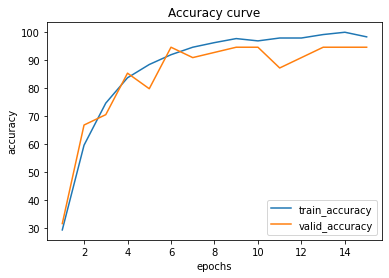

In [14]:
# Curva de la precision durante el entrenamiento. 
plt.plot(np.linspace(1, n_epochs, n_epochs).astype(int), train_acc_vals,label='train_accuracy')
plt.plot(np.linspace(1, n_epochs, n_epochs).astype(int), valid_acc_vals,label='valid_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy curve')

### 6.2. Trazar las curvas de pérdida de entrenamiento y validación

Text(0.5, 1.0, 'loss functions')

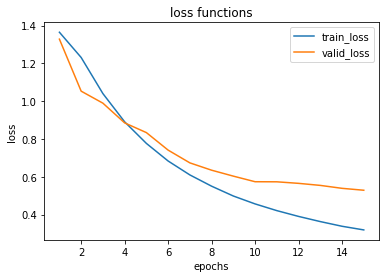

In [15]:
# Reducción del error cuadrático medio durante el entrenamiento. 
plt.plot(np.linspace(1, n_epochs, n_epochs).astype(int), train_loss_vals,label='train_loss')
plt.plot(np.linspace(1, n_epochs, n_epochs).astype(int), valid_loss_vals,label='valid_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('loss functions')

## 7. Evaluar el Modelo

In [16]:
#costo de pruebas
test_loss = 0.0
class_correct = list(0. for i in range(num_classes)) #aciertos por cada clase
class_total = list(0. for i in range(num_classes)) #n° de intentos por cada clase

model.eval()
i=0
# Recorremos el conjunto de prueba
for data, target in test_loader:
    if len(target)!=batch_size:
        continue
        
    # Movemos los tensores al GPU si hay CUDA disponible
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # Forwarding: calcula predicciones de las entradas del modelo
    output = model(data)
    # calculamos costo del lote
    loss = criterion(output, target)
    # Actualizamos el costo del lote
    test_loss += loss.item()*data.size(0)
    # Salida: probabilidades de cada clase -> clase mas probable
    _, pred = torch.max(output, 1)    
    # Comparamos las predicciones con las respuestas correctas -> exito(1)/0(error)
    correct_tensor = pred.eq(target.data.view_as(pred))
    
    #linearizamos el tensor de exito/error
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    #Imprimimos contraste entre prediccion y respuesta correcta
    print('PREDICCIONES:')
    print(pred)
    print('RESPUESTAS CORRECTAS:')
    print(target)
    
    # calculamos la precision de las predicciones por cada clase
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item() #sumamos los aciertos(1)
        class_total[label] += 1 #contamos cada intento de esa clase

# Porcentaje de costo de las pruebas
test_loss = test_loss/len(test_loader.dataset)
print('Costo de pruebas: {:.6f}\n'.format(test_loss))

for i in range(num_classes):
    if class_total[i] > 0:
        print('Accuracy de la clase %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Accuracy de la clase %5s: N/A (Sin ejemplos de entrenamiento)' % (classes[i]))

print('\nAccuracy Total: %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

PREDICCIONES:
tensor([3, 3, 0, 2, 1, 1, 3, 2, 2, 3, 1, 3, 1, 3, 2, 1, 2, 1, 0, 3, 2, 2, 2, 2,
        1, 2, 1, 0, 3, 2, 3, 1])
RESPUESTAS CORRECTAS:
tensor([3, 3, 0, 2, 1, 1, 3, 2, 2, 3, 1, 3, 1, 3, 2, 1, 2, 3, 0, 3, 2, 2, 2, 2,
        1, 3, 1, 0, 3, 2, 3, 1])
Costo de pruebas: 0.005397

Accuracy de la clase Homero: 100% ( 3/ 3)
Accuracy de la clase Marge: 100% ( 8/ 8)
Accuracy de la clase  Bart: 100% (10/10)
Accuracy de la clase  Lisa: 81% ( 9/11)

Accuracy Total: 93% (30/32)


## 8. Predicción de Imagenes

In [17]:
from PIL import Image
from torch.autograd import Variable

#Recibe una imagen y muestra la clase que el modelo determina como mas probable
def predict_image(image_name):
    image = Image.open(image_name)
    image = transform(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #linearizamos
    output = model(image)
    predicted = torch.max(output, 1)
    print( classes[ predicted[1].item()]) #imprime nombre de la clase asociada
    
predict_image('TheSimpson/Testing/2_bart/bart00000.png')

Bart


### 8.1. Preprocesamiento de imágenes

Primero, cambie el tamaño de las imágenes donde el lado más corto es de 256 píxeles, manteniendo la relación de aspecto. Esto se puede hacer con los métodos de miniatura o de cambio de tamaño. Luego, deberá recortar la parte central de 224x224 de la imagen.

Los canales de color de las imágenes generalmente se codifican como números enteros 0-255, pero el modelo esperado flota 0-1. Deberá convertir los valores. Es más fácil con una matriz Numpy, que puede obtener de una imagen PIL como np_image = np.array (pil_image).

Como antes, la red espera que las imágenes se normalicen de una manera específica. Para las medias, es [0.485, 0.456, 0.406] y para las desviaciones estándar [0.229, 0.224, 0.225]. Querrá restar las medias de cada canal de color y luego dividir por la desviación estándar.

Y finalmente, PyTorch espera que el canal de color sea la primera dimensión, pero es la tercera dimensión en la imagen PIL y la matriz Numpy. Puede reordenar las dimensiones utilizando ndarray.transpose. El canal de color debe ser el primero y mantener el orden de las otras dos dimensiones.

In [18]:
from PIL import Image
def process_image(image_path):
    # Abrir la imagen
    img = Image.open(image_path)
    # Ancho, Alto de la imagen
    width, height = img.size
    # Cambiar el tamaño de la imagen
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    # Nuevo ancho, alto de la imagen
    width, height = img.size

    # Recortar la imagen
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Convertir en np array
    img = np.array(img)/255

    # Deshacemos la mean y std, luego transponer
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])  
    img = (img - mean)/std
    img = np.transpose(img, (2, 0, 1))

    img = img[np.newaxis,:]
    image = torch.from_numpy(img)
    image = image.float()
    return image


def predict(image, model):
    output = model.forward(image)
    output = torch.exp(output)
    # probablildad de clase
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

def show_image(image):
    image = image.numpy()
    image[0] = image[0] * 0.226 + 0.445
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Es un  100.0 % probable que sea  Bart


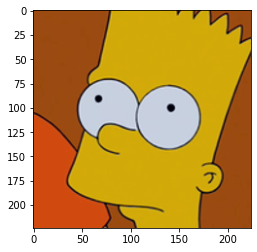

In [19]:
image = process_image("TheSimpson/Testing/2_bart/bart00000.png")

top_prob, top_class = predict(image, model)

show_image(image)

print("Es un ", top_prob*100, "% probable que sea ", classes[top_class]  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Es un  72.67787456512451 % probable que sea  Homero


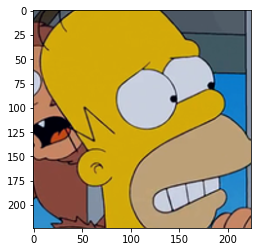

In [20]:
image = process_image("TheSimpson/Testing/0_homero/homero00002.png")

top_prob, top_class = predict(image, model)

show_image(image)

print("Es un ", top_prob*100, "% probable que sea ", classes[top_class]  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Es un  100.0 % probable que sea  Lisa


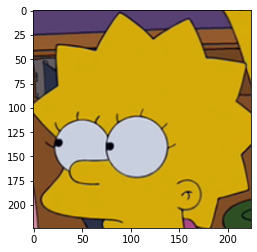

In [21]:
image = process_image("TheSimpson/Testing/3_lisa/lisa00008.png")

top_prob, top_class = predict(image, model)

show_image(image)

print("Es un ", top_prob*100, "% probable que sea ", classes[top_class]  )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Es un  100.0 % probable que sea  Marge


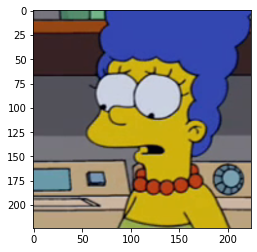

In [22]:
image = process_image("TheSimpson/Testing/1_marge/marge00002.png")

top_prob, top_class = predict(image, model)

show_image(image)

print("Es un ", top_prob*100, "% probable que sea ", classes[top_class]  )